# CS4487 - Course Project Helper Code (2016)
This is helper code for the course project.  Copy the appropriate code into your ipynb.

In [2]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
import IPython.utils.warn as warn
random.seed(100)
import json
import csv

C:\Users\User\Anaconda2\lib\site-packages\sklearn\lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
C:\Users\User\Anaconda2\lib\site-packages\sklearn\qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


# Helper code for "Alphabase"

Below are two helper functions to load the dataset and write the CSV submission file.

In [ ]:
def load_alphabase(fname):
    head = []
    data = []
    with open(fname, 'rU') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        trainingset = False
        for row in reader:
            if len(head) == 0:
                head = row
                if head[-1] == "Target":
                    trainingset = True                
            else:
                # process the list into an array
                for i in range(len(row)):
                    if row[i] == "NA":
                        row[i] = None  
                if trainingset and (row[-1] is None):
                    print "skipping row w/ NA target"
                else:
                    data.append(array(row, dtype=float))

    # concatenate
    data2 = array(data)

    # training set
    if trainingset:
        dataX = data2[:,0:-1]
        dataY = data2[:,-1].astype(int)        
        return dataX, dataY, head[0:-1]
    else:
        # test set
        dataX = data2[:,1:]
        dataID = data2[:,0].astype(int)
        return dataX, dataID, head[1:]

In [ ]:
import csv

def write_csv_alphabase(fname, YID, Yprob):
    # fname = file name
    # Yprob is a list/array with probabilities of class 1
    # YID is the test case ID number
    
    if ndim(Yprob) != 1:
        raise "ERROR: Yprob should be a list of probabilites for class 1"

    # write CSV file
    f = open(fname, 'wb')
    f.write("ID,Target\n")

    # add ID numbers for each Y
    for (i,y) in enumerate(Yprob):
        f.write("%d,%0.9f\n" % (YID[i], y))
        
    f.close()    

Load the dataset.  Some entries in the training set have NA targets, which are ignored.

In [ ]:
trainX, trainY, featnames = load_alphabase('Alphabase/train.csv')
testX, testID, _ = load_alphabase('Alphabase/test.csv')

Here is the dataset size.

In [ ]:
print trainX.shape
print trainY.shape
print testX.shape
print testID.shape

Here is an example training point. You will notice that some entires are "nan", which means they are missing values.

In [ ]:
print trainY[0]
print trainX[0]

You can use `Imputer` to fill-in the missing values with the mean value. You can try some other strategies too.

In [ ]:
# NOTE: does the replacement in place (doesn't make a copy)
imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0, copy=False)
imp.fit(trainX)

# replace the missing values
imp.transform(trainX)
imp.transform(testX);

In [ ]:
print trainX[0]

Here is the class breakdown:

In [ ]:
print "class 0 size: " + str(count_nonzero(trainY==0))
print "class 1 size: " + str(count_nonzero(trainY==1))

There are 55 features in the datasets. For each feature, there are three different methods to process the data, resulting in 165 total features.

Feature columns with titles suffixed by "_mm" are normalised by Min-Max Scaling. Those with titles suffixed by "_z" are z-score of the original data. While the others with titles suffixed by "_p" are percentile rankings of the data.

You can use all 3 types of features, or select only one type.

In [ ]:
featnames

In [ ]:
# make masks for each type of feature
mm_mask = array(map(lambda x: x.endswith('_mm'), featnames))
z_mask  = array(map(lambda x: x.endswith('_z'), featnames))
p_mask  = array(map(lambda x: x.endswith('_p'), featnames))

In [ ]:
# select z-score set
trainXz = trainX[:,z_mask]
testXz  = testX[:,z_mask]
print trainXz.shape
print testXz.shape

In [ ]:
print trainXz[0]

In [ ]:
# select mm-score set
trainXm = trainX[:,mm_mask]
testXm  = testX[:,mm_mask]
print trainXm.shape
print testXm.shape

Here is an example using NB Gaussian classifier. It's not very good.

In [ ]:
# learn simple Naive Bayes Gaussian model
model = naive_bayes.GaussianNB()
model.fit(trainXz, trainY)

# predict probabilities
trainYpred = model.predict_proba(trainXz)

# compute log-loss on the training set
LL = metrics.log_loss(trainY, trainYpred)
print "log-loss = " + str(LL)

In [ ]:
# predict on the test set
testYprob = model.predict_proba(testXz)

# save the submission file
# NOTE: you need to save the probability of class 1
write_csv_alphabase("alphabase_test_nb.csv", testID, testYprob[:,1])

# result: 1.1006474 .

Here is an example using a random classifier.

In [ ]:
# baseline: random prediction. 0.5 probability for each class
testYprob = 0.5*ones((testX.shape[0], 2))
write_csv_alphabase("alphabase_test_random.csv", testID, testYprob[:,1])

# result: 0.6931472

# Helper code for "Allstate Claims Severity"

Two functions to load data and save the submission file.

In [3]:
def load_allstate(fname):
    head = []
    dataID = []
    dataX  = []
    dataY  = []
    catmask = []
    with open(fname, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        trainingset = False
        for row in reader:
            if len(head) == 0:
                head = row
                if head[-1] == "loss":
                    trainingset = True
                    featnames = head[1:-1]
                else:
                    trainingset = False
                    featnames = head[1:]
                catmask = map(lambda x: x.startswith("cat"), featnames)
                
            else:             
                # process the list into an array
                dataID.append(int(row[0]))
                if trainingset:
                    dataY.append(float(row[-1]))
                    tmpX = row[1:-1]
                else:
                    tmpX = row[1:]
                    
                # process data
                for i,v in enumerate(tmpX):
                    # for categorical features, convert string code (e.g "BA") into integer
                    if catmask[i]:
                        if not v.isalpha():
                            print "bad cat: " + v
                            return
                        if len(v) == 1:
                            # single letter -> [0,25]
                            catval = ord(v[0]) - ord("A")
                        elif len(v) == 2:
                            # 2 letters -> 26*(v[0]+1) + v[1]
                            catval = 26*(ord(v[0])-ord("A")+1) + (ord(v[1]) - ord("A"))
                        else:
                            print "ERROR"
                            return
                        
                        tmpX[i] = float(catval)
                    else:
                        # for float features, just convert to float
                        tmpX[i] = float(v)    
                dataX.append(tmpX)

    return array(dataX), array(dataY), array(dataID), featnames, catmask

In [4]:
import csv

def write_csv_allstate(fname, YID, Y):
    # fname = file name
    # Y is the prediction
    # YID is the test case ID number
    
    # write CSV file
    f = open(fname, 'w')
    f.write("id,loss\n")

    # add ID numbers for each Y
    for (i,y) in enumerate(Y):
        f.write("%d,%f\n" % (YID[i], y))
        
    f.close()    

Now load the data and see the size.

In [5]:
# load the data
trainX, trainY, trainID, featnames, catmask = load_allstate("train.csv")
testX, testY, testID, _, _ = load_allstate("test.csv")

In [11]:
print trainX.shape
print trainY.shape
print testX.shape

(188318L, 130L)
(188318L,)
(125546L, 130L)


The first 116 features are categorical features, represented as integers.  The remaining 14 features are continuous values.

In [12]:
print featnames

['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat90', 'cat91', 'cat92', 'cat93', 'cat94', 'cat95', 'cat96', 'cat97', 'cat98', 'cat99', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', 'cat107', 'cat108', 'cat109', 'cat110', 'cat111

Here is an example input/output

In [13]:
print trainX[0]
print trainY[0]

[  0.00000000e+00   1.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00

Next, we remap each categorical feature to have continuous integer values. This makes it easier to process later.

In [6]:
for j in range(trainX.shape[1]):
    if catmask[j]:
        catmap = list(unique(trainX[:,j]))
        print str(j) + ": " + str(len(catmap)) + " : " + str(catmap)
        
        if len(catmap) == max(catmap)+1:
            print "OK"
        else:
            print "remapping"
            for i in range(trainX.shape[0]):
                trainX[i,j] = catmap.index(trainX[i,j])

0: 2 : [0.0, 1.0]
OK
1: 2 : [0.0, 1.0]
OK
2: 2 : [0.0, 1.0]
OK
3: 2 : [0.0, 1.0]
OK
4: 2 : [0.0, 1.0]
OK
5: 2 : [0.0, 1.0]
OK
6: 2 : [0.0, 1.0]
OK
7: 2 : [0.0, 1.0]
OK
8: 2 : [0.0, 1.0]
OK
9: 2 : [0.0, 1.0]
OK
10: 2 : [0.0, 1.0]
OK
11: 2 : [0.0, 1.0]
OK
12: 2 : [0.0, 1.0]
OK
13: 2 : [0.0, 1.0]
OK
14: 2 : [0.0, 1.0]
OK
15: 2 : [0.0, 1.0]
OK
16: 2 : [0.0, 1.0]
OK
17: 2 : [0.0, 1.0]
OK
18: 2 : [0.0, 1.0]
OK
19: 2 : [0.0, 1.0]
OK
20: 2 : [0.0, 1.0]
OK
21: 2 : [0.0, 1.0]
OK
22: 2 : [0.0, 1.0]
OK
23: 2 : [0.0, 1.0]
OK
24: 2 : [0.0, 1.0]
OK
25: 2 : [0.0, 1.0]
OK
26: 2 : [0.0, 1.0]
OK
27: 2 : [0.0, 1.0]
OK
28: 2 : [0.0, 1.0]
OK
29: 2 : [0.0, 1.0]
OK
30: 2 : [0.0, 1.0]
OK
31: 2 : [0.0, 1.0]
OK
32: 2 : [0.0, 1.0]
OK
33: 2 : [0.0, 1.0]
OK
34: 2 : [0.0, 1.0]
OK
35: 2 : [0.0, 1.0]
OK
36: 2 : [0.0, 1.0]
OK
37: 2 : [0.0, 1.0]
OK
38: 2 : [0.0, 1.0]
OK
39: 2 : [0.0, 1.0]
OK
40: 2 : [0.0, 1.0]
OK
41: 2 : [0.0, 1.0]
OK
42: 2 : [0.0, 1.0]
OK
43: 2 : [0.0, 1.0]
OK
44: 2 : [0.0, 1.0]
OK
45: 2 : [0.0, 1.0]
O

We could use the categorical features as is, but there is no relationship between to category numbers.  For example, "category 4" - "category 3" = 1, has no real meaning. 

Instead, we can use "one-hot" encoding, which turns each category feature into a vector.
For example, if the category has three values {1,2,3}:<br>
cat 1 -> [1 0 0]<br>
cat 2 -> [0 1 0]<br>
cat 3 -> [0 0 1]

In [7]:
# use one-hot-encoder to transform the categorical features.
ohe = preprocessing.OneHotEncoder(categorical_features=catmask, handle_unknown='ignore')
ohe.fit(trainX)
# transform - these are no sparse matrices
trainXo = ohe.transform(trainX).tocsr()
testXo  = ohe.transform(testX).tocsr()

The new feature space has more dimensions, but is sparse.

In [16]:
print trainX.shape
print trainXo.shape

(188318L, 130L)
(188318, 1153)


In [17]:
print trainX[0]

[  0.00000000e+00   1.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00

In [19]:
print trainXo[0]

  (0, 0)	1.0
  (0, 3)	1.0
  (0, 4)	1.0
  (0, 7)	1.0
  (0, 8)	1.0
  (0, 10)	1.0
  (0, 12)	1.0
  (0, 14)	1.0
  (0, 17)	1.0
  (0, 18)	1.0
  (0, 21)	1.0
  (0, 22)	1.0
  (0, 24)	1.0
  (0, 26)	1.0
  (0, 28)	1.0
  (0, 30)	1.0
  (0, 32)	1.0
  (0, 34)	1.0
  (0, 36)	1.0
  (0, 38)	1.0
  (0, 40)	1.0
  (0, 42)	1.0
  (0, 45)	1.0
  (0, 46)	1.0
  (0, 48)	1.0
  :	:
  (0, 386)	1.0
  (0, 406)	1.0
  (0, 423)	1.0
  (0, 495)	1.0
  (0, 561)	1.0
  (0, 645)	1.0
  (0, 702)	1.0
  (0, 726)	1.0
  (0, 771)	1.0
  (0, 804)	1.0
  (0, 1094)	1.0
  (0, 1139)	0.7263
  (0, 1140)	0.245921
  (0, 1141)	0.187583
  (0, 1142)	0.789639
  (0, 1143)	0.310061
  (0, 1144)	0.718367
  (0, 1145)	0.33506
  (0, 1146)	0.3026
  (0, 1147)	0.67135
  (0, 1148)	0.8351
  (0, 1149)	0.569745
  (0, 1150)	0.594646
  (0, 1151)	0.822493
  (0, 1152)	0.714843


Finally, the output targets are real numbers, which are highly imbalanced. We can use the log as the training values.

In [8]:
trainYlog = log(trainY)

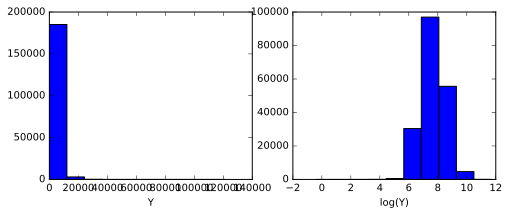

In [21]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.hist(trainY)
plt.xlabel('Y')
plt.subplot(1,2,2)
plt.hist(trainYlog);
plt.xlabel('log(Y)');

Example using linear regression.

In [9]:
ols = linear_model.LinearRegression()
ols.fit(trainXo, trainYlog)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [10]:
trainYlogpred = ols.predict(trainXo)
trainYpred = exp(trainYlogpred)

# calculate MSE in log-output space
MSElog = metrics.mean_squared_error(trainYlog, trainYlogpred)

# calculate MSE in original space
MSE = metrics.mean_squared_error(trainY, trainYpred)

print "MSE_log = " + str(MSElog)
print "MSE     = " + str(MSE)

MSE_log = 0.315029329489
MSE     = 4573377.82436


In [12]:
# predict on test set, and save Kaggle submission file
testYlogpred = ols.predict(testXo)
testYpred = exp(testYlogpred)
write_csv_allstate("allstate_olsT.csv", testID, testYpred)
# Kaggle result: 1816.45239

In [13]:
print ols.coef_[0:400]

[  6.42269601e-02  -3.37799090e-02  -2.36125179e-03   3.28082968e-02
  -3.43630708e-02   6.48101154e-02  -3.75726923e-02   6.80197325e-02
  -1.24889533e-01   1.55336571e-01  -5.81171312e-02   8.85641697e-02
  -4.04036945e-02   7.08507440e-02  -6.75440430e-03   3.72014522e-02
  -6.30856929e-03   3.67556125e-02  -4.65117886e-02   7.69588265e-02
  -5.07173650e-02   8.11644061e-02  -1.42541904e-01   1.72988943e-01
  -4.95159704e-02   7.99630097e-02   3.67759076e-02  -6.32885979e-03
   9.82300451e-03   2.06240430e-02   6.87280803e-02  -3.82810364e-02
   6.83394529e-02  -3.78924049e-02   7.06197450e-02  -4.01726966e-02
   1.49045987e-02   1.55424503e-02   6.03469455e-02  -2.98998970e-02
   1.21479333e-01  -9.10322845e-02   1.43436577e-01  -1.12989529e-01
  -1.58188631e-02   4.62659005e-02   2.47387236e-02   5.70832839e-03
  -5.59643546e-02   8.64114022e-02  -9.39520035e-02   1.24399053e-01
  -5.31564960e-02   8.36035416e-02   1.52126082e-02   1.52344424e-02
  -2.00630468e-02   5.05100982e-02